# Imperfect HWP retardance and fast axis simulation - no meas or matrix noise

Saved residuals to Hamal_residuals_HWP_noise_2_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_fast_axis_offset_0.npy
Saved residuals to Hamal_residuals_HWP_noise_4_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_fast_axis_offset_0.npy
Saved residuals to Hamal_residuals_HWP_noise_6_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_fast_axis_offset_0.npy
Saved residuals to Hamal_residuals_HWP_noise_8_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_fast_axis_offset_0.npy
Saved residuals to Hamal_residuals_HWP_noise_10_matrix_noise_0_additive_tint_60_sub_tint_1_readout_noise_0_HWP_fast_axis_offset_0.npy


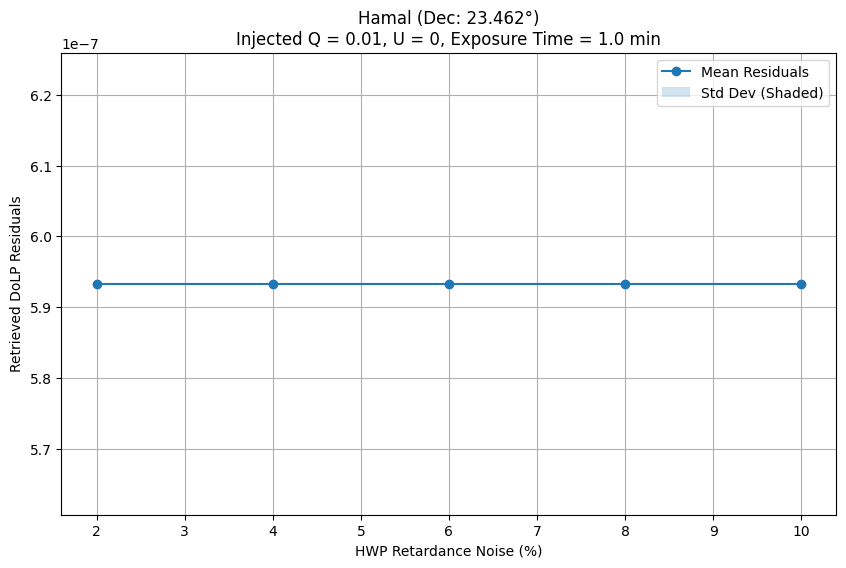

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '../python/')
import angles
import instrument_mm

# Define observer parameters
observer_latitude = 20.0  # Latitude of Mauna Kea in degrees
observer_longitude = -155.5  # Longitude of Mauna Kea in degrees

# Define target parameters
targets = [
    {"name": "Hamal", "ra": 31.791, "dec": 23.462},  # Hamal (Alpha Arietis)
    # {"name": "Mirfak", "ra": 51.079, "dec": 49.861},  # Mirfak (Alpha Persei)
    # {"name": "Polaris", "ra": 37.954, "dec": 89.264},  # Polaris (Alpha Ursae Minoris)
]

# Observation date and time
observation_date = "2460614.91667"  # JD for 10/31/2024
observation_time = "10:00:00"   # UT time to get peak at midnight HST
matrix_noise_type = "additive"

# Fixed integration time and sub-integration time
t_int = 1 * 60  # 1 minute in seconds
sub_tint = 1  # 1 second
num_samples = 100

# Injected polarization
Q_injected = 0.01  # Injected Stokes Q
U_injected = 0  # Injected Stokes U
noise_percentage = 0  # Intensity noise
matrix_noise = 0  # Fixed matrix noise (1%)

# HWP retardance noise levels to test
HWP_noise_levels = np.arange(2, 12, 2) 
delta_HWP = 0.5
delta_HWP_ang = 0 # 5 degrees off
num_trials = 50  # Number of trials per HWP retardance noise

# Loop over each target
for target in targets:
    mean_residuals = []
    std_residuals = []

    # Loop over HWP noise levels
    for HWP_noise in HWP_noise_levels:
        residuals = []

        # Perform multiple trials for each HWP noise level
        for trial in range(num_trials):
            S_in_retrieved = instrument_mm.calculate_input_Q_U_observing_sequence_matrix_inversion(
                ra=target["ra"], 
                dec=target["dec"], 
                observer_latitude=observer_latitude, 
                observer_longitude=observer_longitude, 
                jd_str=observation_date, 
                ut_start=observation_time, 
                t_int=t_int, 
                Q=Q_injected, 
                U=U_injected, 
                delta_HWP=delta_HWP,
                delta_HWP_ang = delta_HWP_ang,
                noise_percentage=noise_percentage,
                include_V=False,
                sub_tint=sub_tint,  # Sub-integration time in seconds
                TMT_matrix_noise=matrix_noise,
                NFIRAOS_matrix_noise=matrix_noise,
                MODHIS_matrix_noise=matrix_noise,
                observable="intensities",  # Or "single_difference" if needed
                sampled_steps=num_samples,
                matrix_noise_type=matrix_noise_type,
                HWP_noise=HWP_noise
            )
            
            # Calculate retrieved polarization
            Q_retrieved, U_retrieved = S_in_retrieved[1], S_in_retrieved[2]
            retrieved_polarization = np.sqrt(Q_retrieved**2 + U_retrieved**2)
            injected_polarization = np.sqrt(Q_injected**2 + U_injected**2)
            
            # Calculate absolute residuals
            residual = np.abs(injected_polarization - retrieved_polarization)
            residuals.append(residual)

        # Compute mean and standard deviation of residuals for this HWP noise level
        mean_residuals.append(np.mean(residuals))
        std_residuals.append(np.std(residuals))

        # Save the residuals as a .npy file
        filename = (
            f"{target['name']}_residuals_HWP_noise_{HWP_noise}_matrix_noise_{matrix_noise}_{matrix_noise_type}_"
            f"tint_{t_int}_sub_tint_{sub_tint}_readout_noise_{noise_percentage}_HWP_fast_axis_offset_{delta_HWP_ang}.npy"
        )
        np.save(filename, np.array(residuals))
        print(f"Saved residuals to {filename}")

    # Plot the results for this target
    plt.figure(figsize=(10, 6))
    mean_residuals = np.array(mean_residuals)
    std_residuals = np.array(std_residuals)
    plt.plot(HWP_noise_levels, mean_residuals, '-o', label=f"Mean Residuals")
    plt.fill_between(HWP_noise_levels, mean_residuals - std_residuals, mean_residuals + std_residuals, alpha=0.2, label="Std Dev (Shaded)")
    plt.xlabel(r"HWP Retardance Noise (%)")
    plt.ylabel("Retrieved DoLP Residuals")
    plt.title(
        f"{target['name']} (Dec: {target['dec']}°)\n"
        f"Injected Q = {Q_injected}, U = {U_injected}, Exposure Time = {t_int / 60:.1f} min"
    )
    plt.grid(True)
    plt.legend()
    plt.show()
